### Nonparametric Kernel Smoothing on Penalty

In [1]:
import pandas as pd 
import numpy as np
from scipy.sparse import dia_matrix, csc_matrix
from scipy.sparse.linalg import inv
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter
import sys
from scipy.interpolate import interp1d
from scipy.stats import iqr
import ruptures as rpt
from sklearn.model_selection import train_test_split
import time

from itertools import chain


path='/home/jbohn/jupyter/personal/'
sys.path.append(f'{path}TAQ-Query-Scripts/data')
sys.path.append(f'{path}Adaptive_Signal_Estimation_Private/')
from trend_filtering.adaptive_tf_ir import adaptive_tf, Dmat
from kernel_smoother import KernelSmoother

### TAQ Data AAPL

Snippet of AAPL trades on NYSE for 1 hour

In [2]:
trades=pd.read_csv(f'{path}TAQ-Query-Scripts/data/cleaned_trades.csv',index_col=0)
trades=trades[trades.index < "2020-01-02 15:59:30"]
trades=trades[trades.index> "2020-01-02 15:59:00"]
trades['Trade_Price']=np.log(trades['Trade_Price'])
trades.index=pd.to_datetime(trades.index)
trades

,SIP_Timestamp,Exchange,Symbol,Trade_Volume,Trade_Price,Sale_Condition,Source_of_Trade,Trade_Correction_Indicator,Sequence_Number,Trade_Id,Trade_Reporting_Facility,Trade_Through_Exempt_Indicator,date
2020-01-02 15:59:00.001618,2020-01-02 15:59:00.001638,Q,AAPL,100,5.705115,@F,N,0,3048096,66973,,1,2020-01-02
2020-01-02 15:59:00.005779,2020-01-02 15:59:00.005800,Q,AAPL,200,5.705115,@,N,0,3048100,66974,,0,2020-01-02
2020-01-02 15:59:00.013466,2020-01-02 15:59:00.013843,P,AAPL,100,5.705115,@F,N,0,3048117,27428,,1,2020-01-02
2020-01-02 15:59:00.017512,2020-01-02 15:59:00.017737,K,AAPL,99,5.705115,@ I,N,0,3048127,18316,,0,2020-01-02
2020-01-02 15:59:00.017641,2020-01-02 15:59:00.018016,P,AAPL,1,5.705115,@ I,N,0,3048130,27429,,0,2020-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 15:59:29.865972,2020-01-02 15:59:29.866183,K,AAPL,100,5.705181,@F,N,0,3073605,18411,,1,2020-01-02
2020-01-02 15:59:29.866298,2020-01-02 15:59:29.866316,Q,AAPL,200,5.705215,@F,N,0,3073606,67525,,1,2020-01-02
2020-01-02 15:59:29.866298,2020-01-02 15:59:29.866320,Q,AAPL,99,5.705215,@F I,N,0,3073607,67526,,1,2020-01-02
2020-01-02 15:59:29.896744,2020-01-02 15:59:29.896763,Q,AAPL,35,5.705148,@F I,N,0,3073623,67527,,1,2020-01-02


Text(0.5, 1.0, 'APPL Trade Price 01/15/2020')

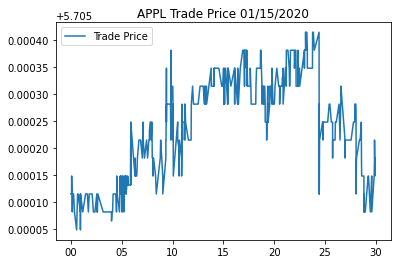

In [3]:
fig,ax=plt.subplots()
ax.plot(trades['Trade_Price'],label='Trade Price')
ax.legend()
ax.xaxis.set_major_formatter(DateFormatter('%S'))
ax.set_title("APPL Trade Price 01/15/2020")

In [4]:
vol=trades['Trade_Volume']

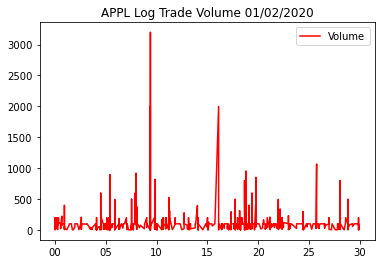

In [5]:
fig,ax=plt.subplots()
ax.set_title("APPL Log Trade Volume 01/02/2020")
ax.xaxis.set_major_formatter(DateFormatter('%S'))
ax.plot(vol,color='red',label='Volume')
ax.legend()

### Compute Max Lambda 

As denoted in L1 Trend Filtering, smallest maximum for which $\forall \lambda \geq \lambda_{max}$ the L1 trend filtering returns the best linear affine fit
$$\lambda_{max}=||(DD^T)^{-1}Dy||_\infty$$

For adaptiveness; one idea to show that the max of each component corresponds to the max of that single partition is that the trivial example of the best affine fit between two points simplify to linear interpolation

In [6]:
def max_norm(y,k=2,adaptive=False,verbose=True):
    """ Computes smallest max norm via scipy sparse matrices for efficiency
    """
    D=Dmat(len(y),k)
    
    D=D.tocsc()
   
    D_DT=inv(D@D.T)
    
    
    if adaptive is False:
        max_lam=abs(D_DT@D@y).max()
    else:
        max_lam=abs(D_DT@D@y)
        
    if verbose:
        print("Condition Number is ",np.linalg.cond((D@D.T).toarray()))
    return max_lam

In [7]:
lambda_val=max_norm(trades['Trade_Price'].values,k=2)
lambda_val

Condition Number is  42845647317.21987


5.643879641426906

Condition Number is  42845647317.21987


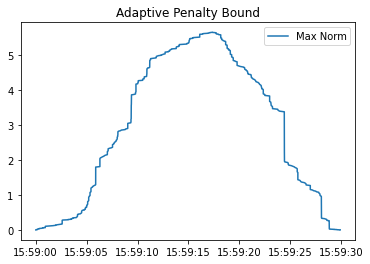

In [8]:
lambda_val=max_norm(trades['Trade_Price'].values,2,True)
plt.title("Adaptive Penalty Bound")

plt.plot(trades['Trade_Price'].index[1:-1],lambda_val,label='Max Norm')
plt.legend()

### Apply Kernel Smoothing on Volume Time Series

Applies Kernel Spatial Smoothing s.t. 

$$\hat{Y}(x_j)=\frac{\sum_{t=1}^T K_\sigma(x_i,x_j)Y(x_i)}{\sum_{t=1}^T K_\sigma(x_i,x_j)}$$ 

Where our kernel function is the Gaussian Kernel

Or we can default to silvermans/scotts (however these have parametric assumptions)

In [9]:
index=(trades['Trade_Volume'].index-trades['Trade_Volume'].index[0]).total_seconds() # reindexed time from [0, last]
    
prior=trades['Trade_Volume'].values

kernel=KernelSmoother(prior,index,0)

kernel.fit()


In [10]:
kernel.fitted_kernel_matrix

array([[1.80171088e-002, 1.79913538e-002, 1.79437261e-002, ...,
        3.99660320e-110, 2.45896253e-110, 1.24463660e-110],
       [1.80170222e-002, 1.79914403e-002, 1.79441310e-002, ...,
        4.28204534e-110, 2.63476986e-110, 1.33375527e-110],
       [1.80164068e-002, 1.79911452e-002, 1.79444254e-002, ...,
        4.86394421e-110, 2.99320485e-110, 1.51547572e-110],
       ...,
       [5.39076312e-110, 5.76754921e-110, 6.53419747e-110, ...,
        1.33575216e-002, 1.36150981e-002, 1.39812433e-002],
       [3.25315300e-110, 3.48077615e-110, 3.94396880e-110, ...,
        1.33540849e-002, 1.36186019e-002, 1.39949309e-002],
       [1.60153871e-110, 1.71376730e-110, 1.94217477e-110, ...,
        1.33377155e-002, 1.36117215e-002, 1.40020050e-002]])

In [11]:
kernel.smooth_series()

kernel.smooth_prior


array([92.11871316, 92.22808102, 92.42868102, ..., 83.82490993,
       82.34688365, 80.26591727])

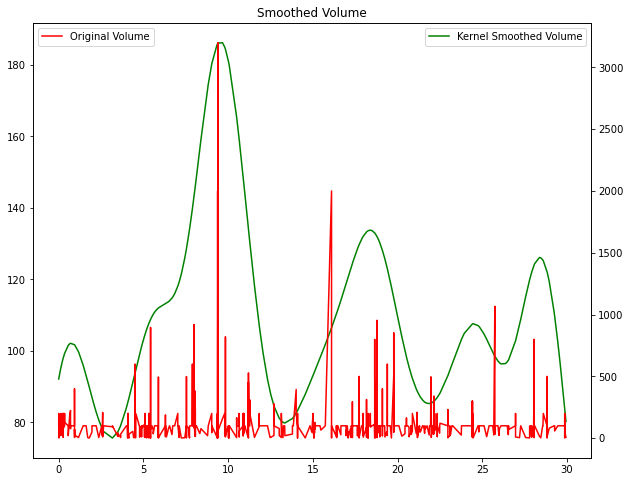

In [12]:
fig,ax=plt.subplots(figsize=(10,8))
ax.plot(index,kernel.smooth_prior,label='Kernel Smoothed Volume',color='green')

ax.set_title("Smoothed Volume")
ax2=ax.twinx()
ax2.plot(index,vol,color='red',label='Original Volume')
ax.legend()
ax2.legend(loc='upper left')

### Arbitrary Evaluation

In [13]:
kernel.evaluate_kernel(2.3)

88.37863605228713

In [14]:
kernel.evaluate_kernel(8.9)

176.6430230516272